In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import optim
from torchvision import transforms
from torchvision.transforms import Normalize

In [2]:
train_data=datasets.CIFAR10(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.Resize(128),
                                  transforms.ToTensor()]))

test_data=datasets.CIFAR10(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.Resize(128),
                                  transforms.ToTensor()]))

100%|██████████| 170M/170M [00:05<00:00, 30.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
image,label=train_data[0]
image.shape

torch.Size([3, 128, 128])

In [4]:
class_names=train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

<ipython-input-5-ca58e497a21c>:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3683.)
  plt.imshow(img.T,cmap='gray')


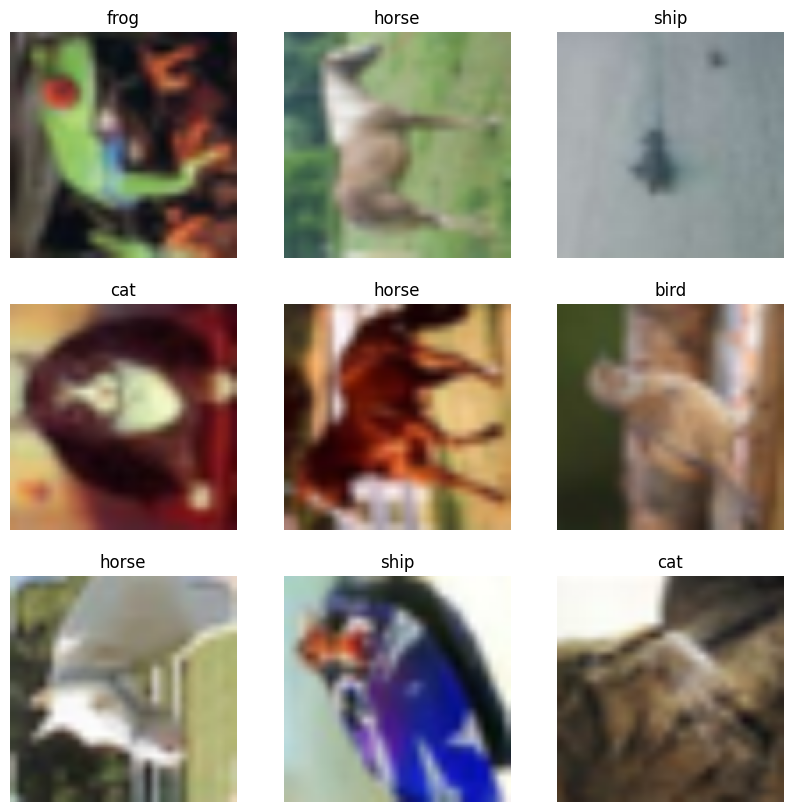

In [5]:
torch.manual_seed(42)

fig=plt.figure(figsize=(10,10))

for i in range(1,10):
  randindx=torch.randint(0,len(train_data),size=[1]).item()
  img,label=train_data[randindx]
  fig.add_subplot(3,3,i)
  plt.imshow(img.T,cmap='gray')
  plt.title(class_names[label])
  plt.axis(False)


In [48]:
from torch.utils.data import DataLoader

batchsize=128


train_dataloader=DataLoader(train_data,batch_size=batchsize,shuffle=True)
test_dataloader=DataLoader(test_data,batch_size=batchsize,shuffle=False)

In [49]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([128, 3, 128, 128]), torch.Size([128]))

In [50]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [51]:
class Generator(nn.Module):
  def __init__(self,z_dim):
    super().__init__()
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(in_channels=z_dim,out_channels=1024,kernel_size=4,stride=2,padding=0),
        #output (1024,4,4)
        nn.BatchNorm2d(1024),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=4,stride=2,padding=1),
        #output (512,8,8)
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=4,stride=2,padding=1),
        #output (256,16,16)
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=4,stride=2,padding=1),
        #output(128,32,32)
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1),
        #output(64,64,64)
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=64,out_channels=3,kernel_size=4,stride=2,padding=1),
        #output (3,128,128)
        nn.Tanh()

    )
  def forward(self,x):
    return self.gen(x)

generator=Generator(100).to(device)

In [52]:
class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.disc=nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),
        nn.Conv2d(in_channels=512,out_channels=1,kernel_size=3,stride=8,padding=0),
        nn.Sigmoid()
    )

    self.flatten=nn.Flatten()

  def forward(self,x):
    out=self.disc(x)
    return self.flatten(out)

discriminator=Discriminator().to(device)

In [54]:
criterion=nn.BCELoss().to(device)
fixed_noise=torch.randn(64,100,1,1,device=device)

optim_g=optim.Adam(generator.parameters(),lr=1e-4)
optim_d=optim.Adam(discriminator.parameters(),lr=1e-4)


In [55]:
print("Starting training loop")

for epoch in range(10):
  for i,(real_images,_) in enumerate(train_dataloader):
    discriminator.zero_grad()
    real_images=real_images.to(device)
    batch_size=real_images.size(0)

    labels=torch.ones(batch_size,1,device=device)
    output=discriminator(real_images)
    lossD_real=criterion(output,labels)
    lossD_real.backward()

    noise=torch.randn(batch_size,100,1,1,device=device)
    gen_images=generator(noise)
    labels=torch.zeros(batch_size,1,device=device)
    output=discriminator(gen_images.detach())
    lossD_fake=criterion(output,labels)
    lossD_fake.backward()

    optim_d.step()

    generator.zero_grad()
    labels.fill_(1)
    output=discriminator(gen_images)
    lossG=criterion(output,labels)
    lossG.backward()
    optim_g.step()

  print(f"Epoch{epoch}:LossD={lossD_real+lossD_fake}:lossG={lossG}")


Starting training loop
Epoch0:LossD=0.010375508107244968:lossG=5.499721050262451
Epoch1:LossD=0.010506055317819118:lossG=7.247951030731201
Epoch2:LossD=0.012813908979296684:lossG=5.583133697509766
Epoch3:LossD=0.0032318895682692528:lossG=6.8106231689453125
Epoch4:LossD=0.0016949925338849425:lossG=7.6721391677856445
Epoch5:LossD=0.061797719448804855:lossG=7.912206172943115
Epoch6:LossD=0.1554863303899765:lossG=4.777693748474121
Epoch7:LossD=0.005167100112885237:lossG=7.6448588371276855
Epoch8:LossD=0.053355421870946884:lossG=4.684159755706787
Epoch9:LossD=0.06036556139588356:lossG=6.3040289878845215


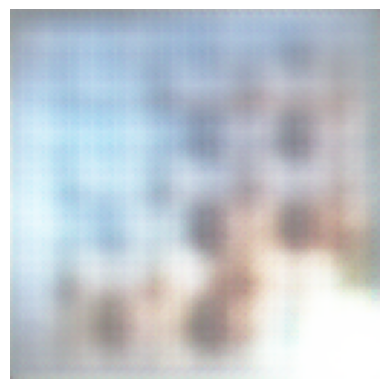

In [69]:
generator.eval()

noise=torch.randn(1,100,1,1,device=device)

with torch.no_grad():
  generated_image_1=generator(noise)


# Denormalize (assuming tanh output)
generated_image = (generated_image_1 + 1) / 2  # Scale from [-1, 1] to [0, 1]
generated_image = generated_image.clamp(0, 1)

import torchvision.transforms as T

# Convert tensor to PIL Image for display
to_pil = T.ToPILImage()
pil_image = to_pil(generated_image.squeeze(0))  # Remove batch dimension
pil_image.save("generated_image.png")  # Save to file

# Or display it directly
plt.imshow(pil_image)
plt.axis("off")
plt.show()